In [1]:
import os
import pyodbc
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
SEED = 1729
sns.set_theme(style='whitegrid')

## Connect to database
The present working directory should contain a file `.env` with the line `SPACECHALLENGE_DB_CONN_STR='{your db connecion string}'`.

In [3]:
load_dotenv()
db_conn_str = os.environ['SPACECHALLENGE_DB_CONN_STR']

In [4]:
dataset_query = """
select
    ah.AssignmentID, b.BookingID, sta.AgentID
    -- dependent var
    ,b.PackageRevenue
    ,b.BookingStatus
    -- vars we know about customer
    ,ah.CustomerName, ah.CommunicationMethod, ah.LeadSource, b.Destination, b.LaunchLocation
    -- vars we know about agent
    ,sta.JobTitle, sta.DepartmentName, sta.ManagerName, sta.YearsOfService, sta.AverageCustomerServiceRating
    -- datetime vars
    ,ah.AssignedDateTime, b.BookingCompleteDate, b.CancelledDate
    -- other rev values
    ,b.DestinationRevenue, b.TotalRevenue
from assignment_history ah
left join bookings b
    on ah.AssignmentID = b.AssignmentID
left join space_travel_agents sta
    on sta.AgentID = ah.AgentID
order by ah.AssignmentID
"""
with pyodbc.connect(db_conn_str) as conn:
    with conn.cursor() as cursor:
        dataset_df = pd.read_sql(dataset_query, conn)

/var/folders/9h/8rdmtj8j6g17zl5bvhyvtd9h0000gn/T/ipykernel_43607/1657903215.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset_df = pd.read_sql(dataset_query, conn)


In [5]:
dataset_df

,AssignmentID,BookingID,AgentID,PackageRevenue,BookingStatus,CustomerName,CommunicationMethod,LeadSource,Destination,LaunchLocation,JobTitle,DepartmentName,ManagerName,YearsOfService,AverageCustomerServiceRating,AssignedDateTime,BookingCompleteDate,CancelledDate,DestinationRevenue,TotalRevenue
0,1,1.0,7,25000.0,Confirmed,Evelyn Brooks,Phone Call,Organic,Mars,Dallas-Fort Worth Launch Complex,Space Travel Agent,Interplanetary Sales,Lyra Chen,4,4.5,2081-02-01 09:00:00,2081-02-01 10:00:00,NaT,150000.0,175000.0
1,2,2.0,14,20000.0,Cancelled,Lucas Chen,Text,Bought,Europa,New York Orbital Gateway,Lead Space Travel Agent,Luxury Voyages,Zane Holloway,16,4.2,2081-02-01 10:30:00,NaT,2081-02-01 11:00:00,120000.0,140000.0
2,3,NaN,3,NaN,None,Amara Patel,Text,Organic,None,None,Senior Space Travel Agent,Premium Bookings,Zane Holloway,15,4.0,2081-02-01 11:15:00,NaT,NaT,NaN,NaN
3,4,3.0,25,30000.0,Confirmed,Jasper Kim,Phone Call,Bought,Titan,Dubai Interplanetary Hub,Space Travel Agent,Interplanetary Sales,Lyra Chen,5,4.4,2081-02-01 13:00:00,2081-02-01 13:30:00,NaT,140000.0,170000.0
4,5,4.0,7,25000.0,Cancelled,Zara Singh,Text,Organic,Mars,Dallas-Fort Worth Launch Complex,Space Travel Agent,Interplanetary Sales,Lyra Chen,4,4.5,2081-02-01 14:20:00,NaT,2081-02-01 15:10:00,150000.0,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,446,408.0,24,20000.0,Cancelled,Callahan Rivera,Text,Bought,Europa,Tokyo Spaceport Terminal,Senior Space Travel Agent,Premium Bookings,Zane Holloway,13,4.3,2081-04-10 10:20:00,NaT,2081-04-10 10:45:00,120000.0,140000.0
446,447,409.0,16,25000.0,Confirmed,Elowen Bell,Phone Call,Organic,Venus,Dubai Interplanetary Hub,Senior Space Travel Agent,Premium Bookings,Zane Holloway,12,4.0,2081-04-10 11:30:00,2081-04-10 12:00:00,NaT,130000.0,155000.0
447,448,410.0,2,30000.0,Confirmed,Tinsley Ross,Text,Bought,Mars,Dallas-Fort Worth Launch Complex,Space Travel Agent,Luxury Voyages,Lyra Chen,7,4.0,2081-04-10 12:40:00,2081-04-10 13:10:00,NaT,150000.0,180000.0
448,449,411.0,20,20000.0,Confirmed,Arlo King,Text,Organic,Titan,New York Orbital Gateway,Space Travel Agent,Luxury Voyages,Zane Holloway,2,4.4,2081-04-10 13:50:00,2081-04-10 14:25:00,NaT,140000.0,160000.0


In [6]:
dataset_df.columns

Index(['AssignmentID', 'BookingID', 'AgentID', 'PackageRevenue',
       'BookingStatus', 'CustomerName', 'CommunicationMethod', 'LeadSource',
       'Destination', 'LaunchLocation', 'JobTitle', 'DepartmentName',
       'ManagerName', 'YearsOfService', 'AverageCustomerServiceRating',
       'AssignedDateTime', 'BookingCompleteDate', 'CancelledDate',
       'DestinationRevenue', 'TotalRevenue'],
      dtype='object')

In [7]:
df = dataset_df.copy()[~(dataset_df['BookingID'].isna() | (dataset_df['BookingStatus'] == 'Pending'))].reset_index(drop=True)

df = df.assign(FinalDate=df['BookingCompleteDate'].fillna(df['CancelledDate']).dt.date)
df = df.assign(RealizedRevenue=df.apply(lambda x: x['PackageRevenue'] if x['BookingStatus']!='Cancelled' else 0, axis=1))
df = df.assign(ConfirmedRevenue=df.apply(lambda x: x['PackageRevenue'] if x['BookingStatus']!='Cancelled' else np.nan, axis=1))
df = df.assign(IsConfirmed=(df['BookingStatus']=='Confirmed').astype(int))
df = df.sort_values(['AgentID', 'FinalDate'])

Text(0.5, 1.0, 'Bookings by LaunchLocation')

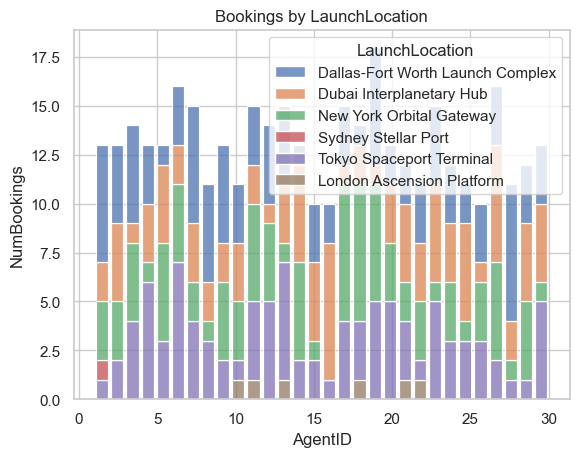

In [8]:
bookings_by_var = 'LaunchLocation'

s = df.groupby(['AgentID', bookings_by_var])['BookingID'].count().rename('NumBookings')

ax = sns.histplot(
    s.to_frame(), 
    x='AgentID', 
    bins=30, 
    hue=bookings_by_var, 
    weights='NumBookings', 
    multiple='stack', 
    shrink=0.8,
)
ax.set_ylabel('NumBookings')
ax.set_title(f'Bookings by {bookings_by_var}')

Text(0.5, 1.0, 'Bookings by Destination')

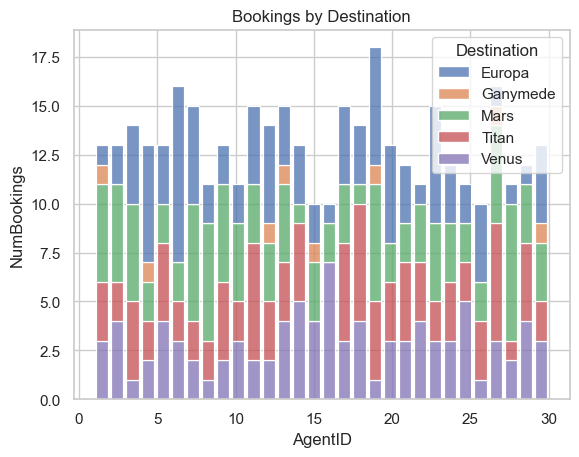

In [9]:
bookings_by_var = 'Destination'

s = df.groupby(['AgentID', bookings_by_var])['BookingID'].count().rename('NumBookings')

ax = sns.histplot(
    s.to_frame(), 
    x='AgentID', 
    bins=30, 
    hue=bookings_by_var, 
    weights='NumBookings', 
    multiple='stack', 
    shrink=0.8,
)
ax.set_ylabel('NumBookings')
ax.set_title(f'Bookings by {bookings_by_var}')

Text(0.5, 1.0, 'Bookings by LeadSource')

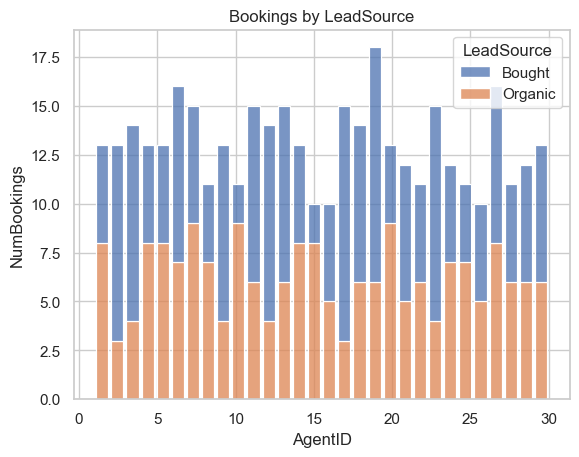

In [10]:
bookings_by_var = 'LeadSource'

s = df.groupby(['AgentID', bookings_by_var])['BookingID'].count().rename('NumBookings')

ax = sns.histplot(
    s.to_frame(), 
    x='AgentID', 
    bins=30, 
    hue=bookings_by_var, 
    weights='NumBookings', 
    multiple='stack', 
    shrink=0.8,
)
ax.set_ylabel('NumBookings')
ax.set_title(f'Bookings by {bookings_by_var}')

Text(0.5, 1.0, 'Bookings by CommunicationMethod')

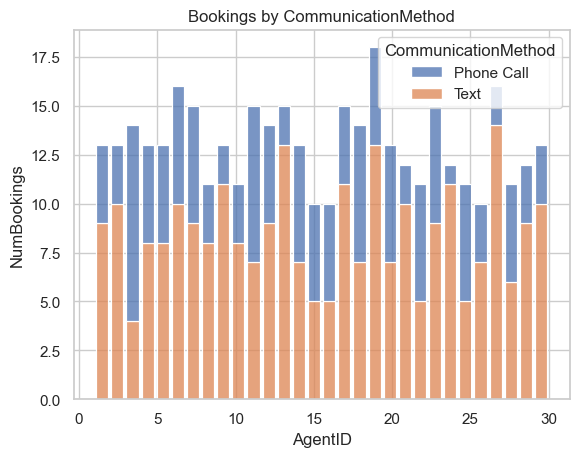

In [11]:
bookings_by_var = 'CommunicationMethod'

s = df.groupby(['AgentID', bookings_by_var])['BookingID'].count().rename('NumBookings')

ax = sns.histplot(
    s.to_frame(), 
    x='AgentID', 
    bins=30, 
    hue=bookings_by_var, 
    weights='NumBookings', 
    multiple='stack', 
    shrink=0.8,
)
ax.set_ylabel('NumBookings')
ax.set_title(f'Bookings by {bookings_by_var}')

Does a greater number of bookings with the `agent_agg_var` {`'Destination'`, `'LaunchLocation'`} variable translate to higher average rev for that variable? 
* `'Destination'` - No
* `'LaunchLocation'` - No
* Separating by `'CommunicationMethod'`, `'LeadSource'`, `'JobTitle'`, `'DepartmentName'` yield no results either. 

In [33]:
agent_agg_var = 'Destination'
# agent_agg_var = 'LaunchLocation'


chart_col = 'DepartmentName'

groupby_list = ['AgentID', agent_agg_var]
groupby_list = groupby_list + [chart_col] if chart_col else groupby_list
data = df.groupby(groupby_list).agg({
    'BookingID': 'count', 
    'RealizedRevenue': 'mean',
    'ConfirmedRevenue': 'mean',
    'IsConfirmed': 'mean'
}).rename(columns={
    'BookingID': 'NumBookings',
    'RealizedRevenue': 'AvgRealizedRevenue',
    'ConfirmedRevenue': 'AvgConfirmedRevenue',
    'IsConfirmed': 'ConfirmedPercent',
})

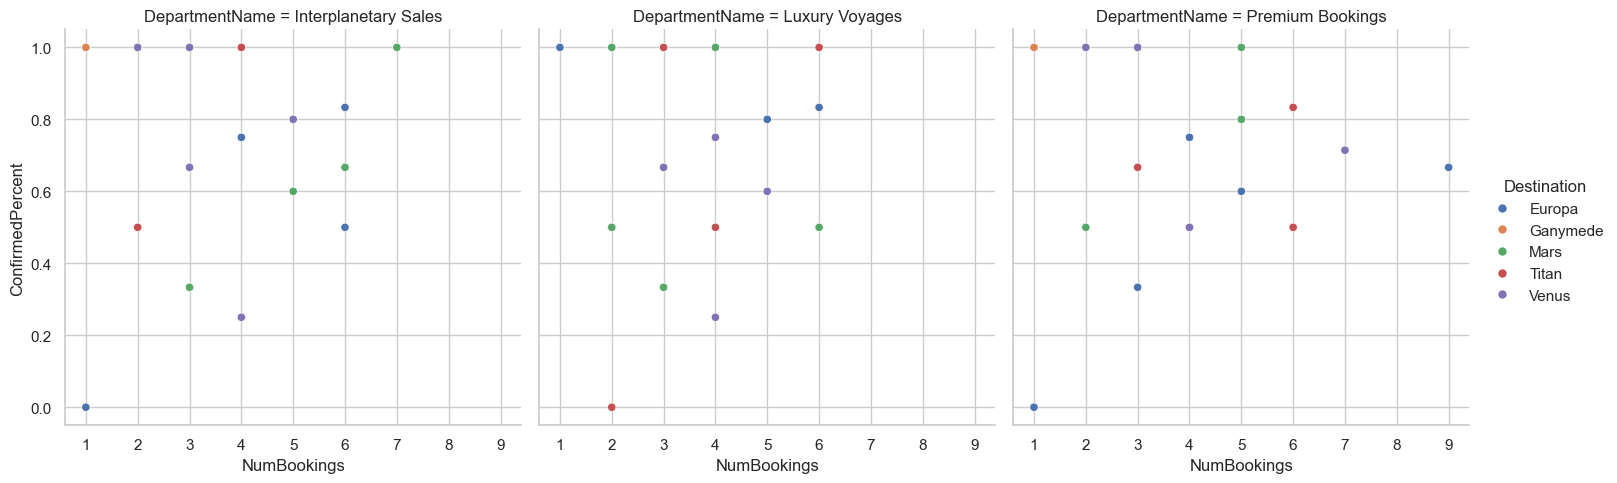

In [34]:
sns.relplot(
    data=data.reset_index(),
    x='NumBookings',
    y='ConfirmedPercent',
    hue=agent_agg_var,
    col=chart_col,
)

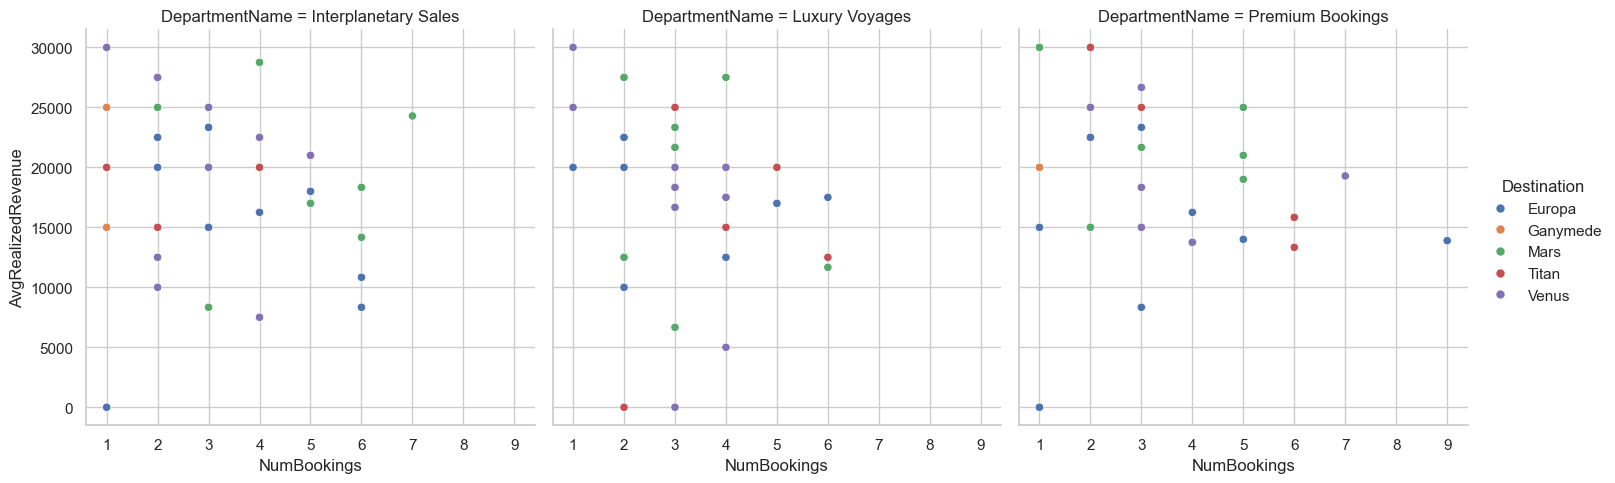

In [35]:
sns.relplot(
    data=data.reset_index(),
    x='NumBookings',
    y='AvgRealizedRevenue',
    hue=agent_agg_var,
    col=chart_col,
)

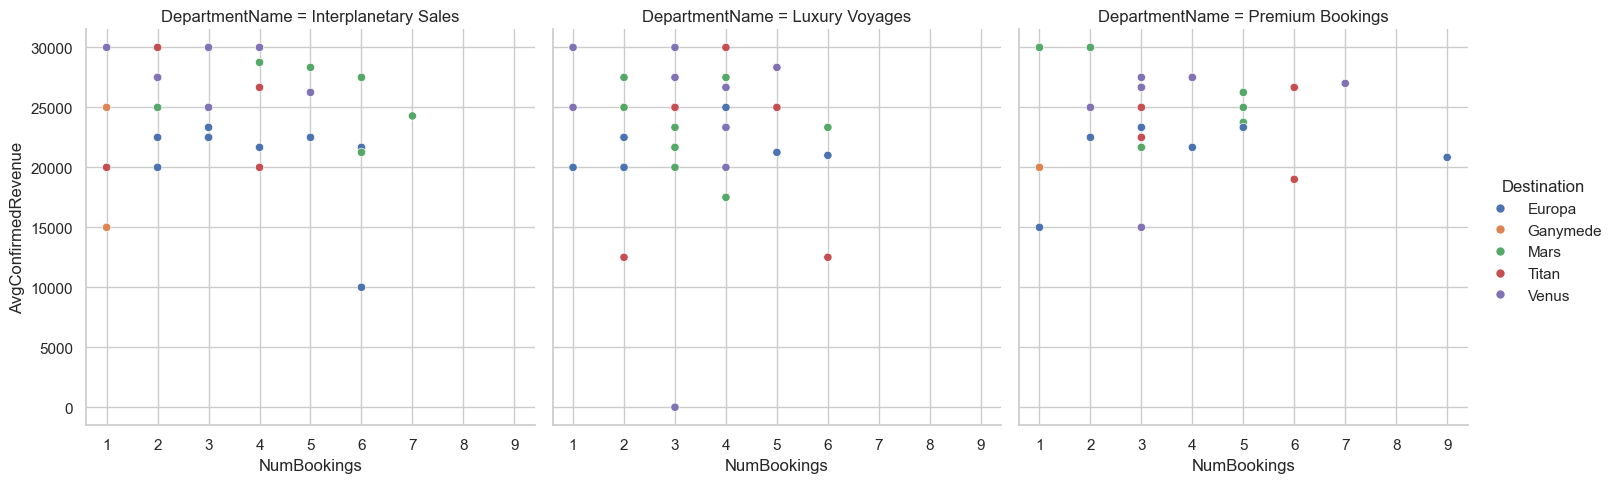

In [36]:
sns.relplot(
    data=data.reset_index(),
    x='NumBookings',
    y='AvgConfirmedRevenue',
    hue=agent_agg_var,
    col=chart_col,
)

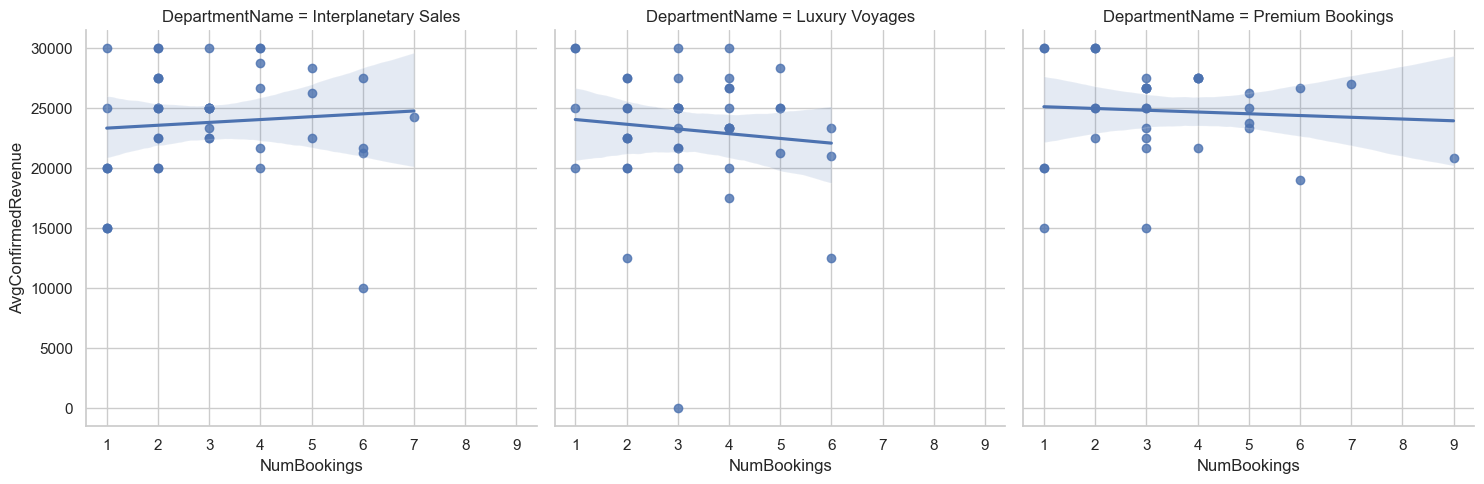

In [39]:
sns.lmplot(
    data=data.reset_index(),
    x='NumBookings',
    y='AvgConfirmedRevenue',
    # hue='Destination',
    col=chart_col,
)

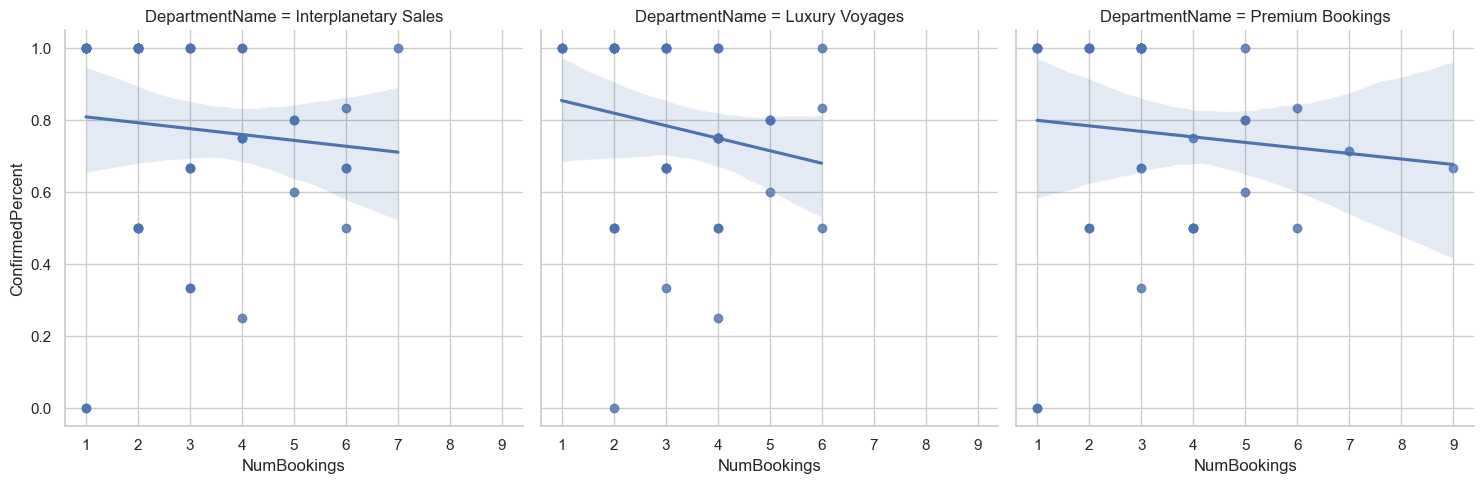

In [41]:
sns.lmplot(
    data=data.reset_index(),
    x='NumBookings',
    y='ConfirmedPercent',
    # hue=agent_agg_var,
    col=chart_col,
)

<Axes: xlabel='NumBookings', ylabel='AvgConfirmedRevenue'>

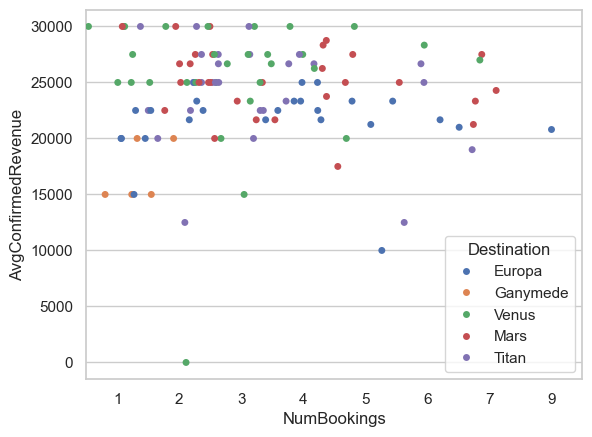

In [43]:
sns.stripplot(
    data=data.reset_index(),
    x='NumBookings',
    y='AvgConfirmedRevenue',
    jitter=1,
    hue=agent_agg_var,
)

<Axes: xlabel='NumBookings', ylabel='ConfirmedPercent'>

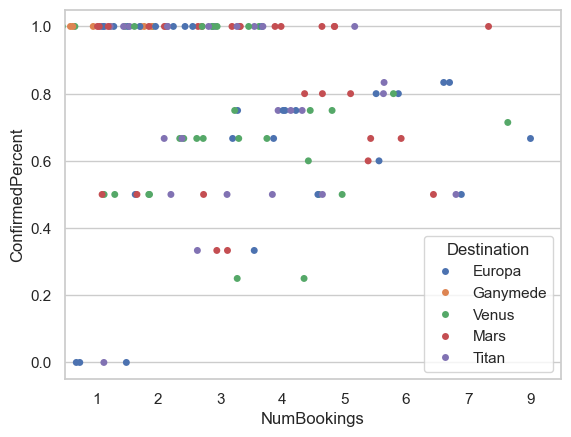

In [19]:
sns.stripplot(
    data=data.reset_index(),
    x='NumBookings',
    y='ConfirmedPercent',
    jitter=1,
    hue=agent_agg_var,
)

Do agents with more experience or higher rating have higher package revenue? 

In [20]:
df.columns

Index(['AssignmentID', 'BookingID', 'AgentID', 'PackageRevenue',
       'BookingStatus', 'CustomerName', 'CommunicationMethod', 'LeadSource',
       'Destination', 'LaunchLocation', 'JobTitle', 'DepartmentName',
       'ManagerName', 'YearsOfService', 'AverageCustomerServiceRating',
       'AssignedDateTime', 'BookingCompleteDate', 'CancelledDate',
       'DestinationRevenue', 'TotalRevenue', 'FinalDate', 'RealizedRevenue',
       'ConfirmedRevenue', 'IsConfirmed'],
      dtype='object')

In [44]:
# groupby_var = 'AverageCustomerServiceRating'
groupby_var = 'YearsOfService'
data = df.groupby(groupby_var).agg({
    'BookingID': 'count',
    'PackageRevenue': 'mean',
    'RealizedRevenue': 'mean',
    'ConfirmedRevenue': 'mean',
    'IsConfirmed': 'mean',
}).rename(columns={
    'BookingID': 'NumBookings',
    'PackageRevenue': 'AvgPackageRevenue',
    'RealizedRevenue': 'AvgRealizedRevenue',
    'ConfirmedRevenue': 'AvgConfirmedRevenue',
    'IsConfirmed': 'ConfirmedPercent',
}).reset_index()

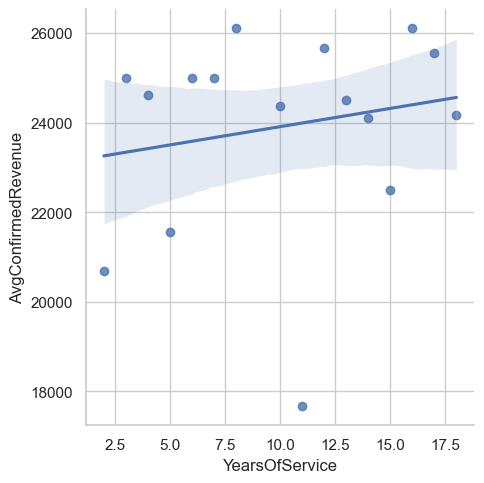

In [45]:
sns.lmplot(
    data=data,
    x=groupby_var,
    y='AvgConfirmedRevenue',
    ci=90,
)